<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Start/SequentialAPI/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2


## Coding tutorials

#### [1. Hello TensorFlow!](#coding_tutorial_1)

<a id='coding_tutorial_1'></a>
## Hello TensorFlow!

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

batch_size = 64

ds_train = tf.data.Dataset.from_tensor_slices(tensors=(x_train, y_train))
ds_train = ds_train.map(map_func=lambda x, y: (
    tf.cast(x=x, dtype=tf.float32)/255., y))
ds_train = ds_train.map(map_func=lambda x, y: (
    tf.reshape(x, (784,)), y))
ds_train = ds_train.shuffle(buffer_size=len(ds_train))\
    .batch(batch_size=batch_size)
print("Train element spec:", ds_train.element_spec)

ds_test = tf.data.Dataset.from_tensor_slices(tensors=(x_test, y_test))
ds_test = ds_test.map(map_func=lambda x, y:
    (tf.cast(x=x, dtype=tf.float32)/255., y))
ds_test = ds_test.map(map_func=lambda x, y: (
    tf.reshape(x, (784,)), y))
ds_test = ds_test.batch(batch_size=batch_size)
print("Test element spec:", ds_test.element_spec)

Train element spec: (TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))
Test element spec: (TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))


In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

class FeaturesExtractor(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(units=16,
            activation=tf.keras.activations.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))
        
    def call(self, inputs):
        return self.dense(inputs)

class Classifier(tf.keras.layers.Layer):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(units=num_classes,
            activation=tf.keras.activations.softmax,
            kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))
    
    def call(self, inputs):
        return self.dense(inputs)

inputs = tf.keras.Input(shape=(784,), name="digits")
h1 = FeaturesExtractor()(inputs)
outputs = Classifier(num_classes=10)(h1)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)
    grads = tape.gradient(target=loss,
        sources=model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(
        grads, model.trainable_variables))
    train_loss.update_state(values=loss)
    train_acc.update_state(y_true=y, y_pred=y_pred)

test_loss = tf.keras.metrics.Mean()
test_acc = tf.keras.metrics.SparseCategoricalAccuracy()
@tf.function
def test_step(x, y):
    y_pred = model(inputs=x, training=False)
    loss = loss_fn(y_true=y, y_pred=y_pred)
    test_loss.update_state(values=loss)
    test_acc.update_state(y_true=y, y_pred=y_pred)

Time taken: 35.07s


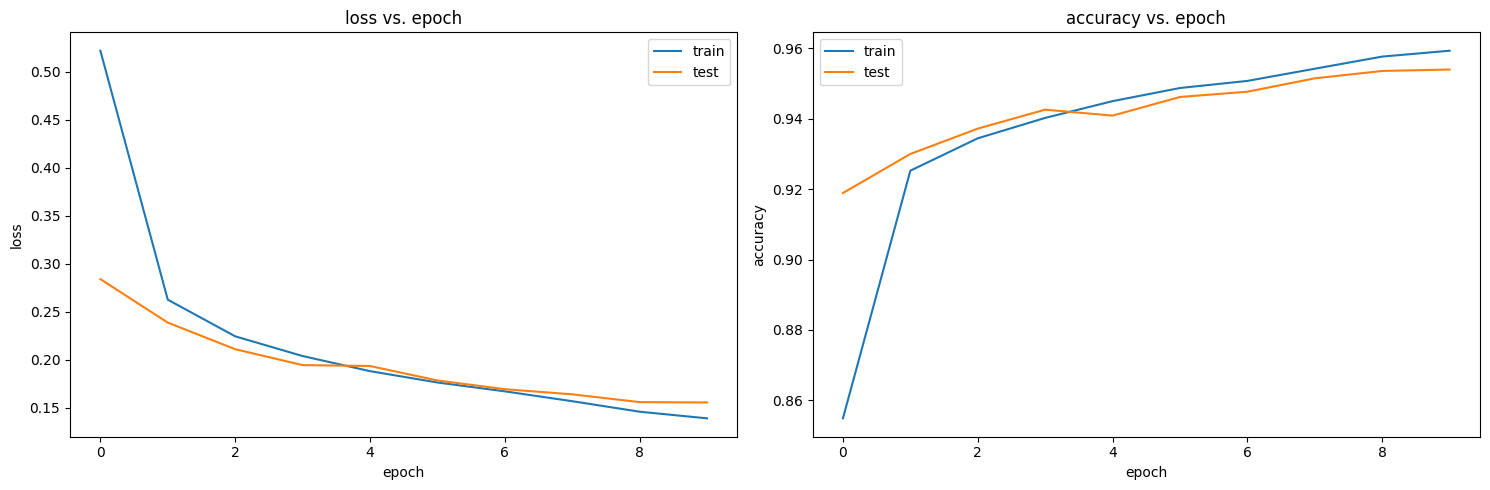

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

history = {
    "train_loss": [], "train_accuracy": [],
    "test_loss": [], "test_accuracy": []
}

start_time = time.time()

num_epoch = 10
for _ in range(num_epoch):
    
    for x, y in ds_train:
        train_step(x, y)

    history["train_loss"].append(train_loss.result().numpy())
    train_loss.reset_state()
    history["train_accuracy"].append(train_acc.result().numpy())
    train_acc.reset_state()

    for x, y in ds_test:
        test_step(x, y)
    
    history["test_loss"].append(test_loss.result().numpy())
    test_loss.reset_state()
    history["test_accuracy"].append(test_acc.result().numpy())
    test_acc.reset_state()

print("Time taken: %.2fs"%(time.time() - start_time))

metrics = ["loss", "accuracy"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, metric in zip(axes, metrics):
    sns.lineplot(ax=ax, label="train",
        x=range(num_epoch), y=history[f"train_{metric}"]
    )
    try:
        sns.lineplot(ax=ax, label="test",
            x=range(num_epoch), y=history[f"test_{metric}"]
        )
    except Exception:
        pass
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{metric}")
    ax.set_title(label=f"{metric} vs. epoch")
fig.tight_layout()
plt.show()